In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import *
from collections import *
import collections
import heapq

#!pip install prince

from prince import FAMD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder

from itertools import combinations
from collections import defaultdict, Counter


import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

## 1. Recommendation system 
Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user. 

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user. 

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.


In [5]:
df = pd.read_csv('/home/theballer/Desktop/Sapienza Courses/ADM/ADM-HW4-Dataset/vodclickstream_uk_movies_03.csv')

In [6]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


### Top movies clicked by the users in total.

So, here I have grouped by title and genres first and used count method, after I sorted by duration, which is basically sorting by count number, not by the values of duration itself, because I used group by on them all the columns will have the count number, instead of regular numbers.

In [7]:
df.groupby(by=['title', 'genres']).count().sort_values(by='duration', ascending=False).reset_index()[['title', 'genres']].head(10)

,title,genres
0,Black Mirror: Bandersnatch,"Drama, Mystery, Sci-Fi, Thriller"
1,Bright,"Action, Fantasy, Thriller"
2,Avengers: Age of Ultron,"Action, Adventure, Sci-Fi"
3,Annihilation,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr..."
4,Hot Fuzz,"Action, Comedy, Mystery, Thriller"
5,Deadpool,"Action, Adventure, Comedy, Sci-Fi"
6,Bird Box,"Drama, Horror, Sci-Fi"
7,FYRE: The Greatest Party That Never Happened,"Documentary, Music"
8,The Big Short,"Biography, Comedy, Drama, History"
9,The Hitman's Bodyguard,"Action, Comedy, Crime, Thriller"


### 1.2 Minhash Signatures 
Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.


In [8]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


### Idea for solving 

First of all, let's create a dataframe with all genres that have been watched by unique users. So, we can use it for further calculations and for creation of a signature matrix.

In [9]:
# df_lsh will contain only user_id and genres
df_lsh = df.loc[:,['user_id', 'genres']] 

In [10]:
stemmer = PorterStemmer()
#drop potential null values from the description column
df_lsh = df_lsh.dropna(subset=['genres'])
#uses apply method with list comprehension to tokenize each row and stem each genre
df_lsh['genres_clean'] = df_lsh.genres.apply(lambda row: [stemmer.stem(word) for word in nltk.word_tokenize(row)])

In [11]:
# I noticed that there are some redundant words and symbols, which I will take away
remove_words = [',', 'avail', 'not']
df_lsh.genres_clean = df_lsh.genres_clean.apply(lambda row: [word for word in row if word not in remove_words]) 

In [12]:
# Let's add unique genres to out vocabulary set
vocabulary = set()
df_lsh.genres_clean.apply(lambda row: [vocabulary.add(word) for word in row]) 

0                           [None, None, None]
1                     [None, None, None, None]
2                                 [None, None]
3                                 [None, None]
4         [None, None, None, None, None, None]
                          ...                 
671731                                  [None]
671732          [None, None, None, None, None]
671733                      [None, None, None]
671734                            [None, None]
671735                            [None, None]
Name: genres_clean, Length: 671736, dtype: object

In [13]:
df_lsh.head()

,user_id,genres,genres_clean
0,1dea19f6fe,"Comedy, Drama, Romance","[comedi, drama, romanc]"
1,544dcbc510,"Fantasy, Horror, Mystery, Thriller","[fantasi, horror, mysteri, thriller]"
2,7cbcc791bf,"Action, Thriller","[action, thriller]"
3,ebf43c36b6,"Action, Drama","[action, drama]"
4,a57c992287,"Animation, Action, Adventure, Comedy, Family, ...","[anim, action, adventur, comedi, famili, fantasi]"


### Notice

In the above dataframe we already have a list of genres that user watched, but they are not unique, thus, let us use grouby with sum, so the lists of the same users will be added together.

In [14]:
df_lsh = df_lsh.groupby(by='user_id').agg({'genres_clean': 'sum'})

In [15]:
# Let's remove repeated values from the lists just by converting them to set
df_lsh.genres_clean = df_lsh.genres_clean.apply(lambda row: set(row))

In [16]:
df_lsh = df_lsh.reset_index()

In [17]:
# We have to convert vocabulary and the watched genres by the users again to the list, so we can easily work further
vocabulary = list(vocabulary)
df_lsh.genres_clean = df_lsh.genres_clean.apply(lambda row: list(row))

In [18]:
# Here is the final df_lsh, that has unique user ids with all the genres that was watched by the particular user.
df_lsh.head()

,user_id,genres_clean
0,00004e2862,"[drama, crime, thriller]"
1,000052a0a0,"[drama, mysteri, anim, fantasi, music, sci-fi,..."
2,000090e7c8,"[sci-fi, mysteri, thriller]"
3,000118a755,[horror]
4,000296842d,"[drama, sci-fi, mysteri, thriller]"


### Creation of the Signature Matrix

In order to create signature matrix, first we have to create shingles, the index of which will be hashed for creation of the signature matrix. So, in case of some sentences we could have used shingles of two characters, however, here we have specific information, which are genres. Thus, I have decided to use genres as my shingles. 

Let's use dictionary comprehension for creation of shingles with unique identifiers, they will serve as the row ids that will be hashed in the future.

In [19]:
shingle_dict = {genre: i for i, genre in enumerate(vocabulary)}

In [20]:
shingle_dict

{'fantasi': 0,
 'music': 1,
 'thriller': 2,
 'sport': 3,
 'documentari': 4,
 'action': 5,
 'new': 6,
 'mysteri': 7,
 'biographi': 8,
 'talk-show': 9,
 'adventur': 10,
 'crime': 11,
 'western': 12,
 'war': 13,
 'anim': 14,
 'romanc': 15,
 'horror': 16,
 'famili': 17,
 'drama': 18,
 'sci-fi': 19,
 'reality-tv': 20,
 'comedi': 21,
 'film-noir': 22,
 'histori': 23,
 'short': 24}

### Approach

In order to create a signature matrix, we do not need to use the one hot encoding vectores with the genres that every user has watched and permute them further. This is too time consuming. So, the idea is that we really should avoid matrix with most of the values that are zeros. We only care about the values that are ones. 

Therefore, we use shingle dict that was created above as the true row ids, then let's say that some particular user is watching thriller, sport and crime. We know their true row ids are 24, 23 and 20 respectively. We will use one has function for all users for creating the one row of the signature matrix, hence, we will hash those values of true row ids and take the minimum output from three values and put it to the signature matrix. 

Now, as the idea of using hash functions and shingle dict is clear, let's explain my approach. I will use 10 different hash functions to create 10 outputs for some particular user's genre, update the signature matrix and go to the next genre of that user and so on untill I finish with one user. This, then iteratively performed on all other users.

In [21]:
N = len(shingle_dict)
n_sig = 10
# Our hash will be (a*x + b) % N, where a and b are random numbers in range of N
# Here params will be a and b for all 10 hash functions
params = np.random.randint(N, size=[n_sig,2])

In [22]:
# We will use this hash function, to hash the row ids
# The hash function is basically (a*x + b) % N
def _permuteRow(row):
    return (params@np.array([1, row]))%N

In [23]:
# Let's create a signature matrix with all values as infinity, we make them infinity, 
# so they will be changed with the outputs from the hash functions 
# notice that in our signature matrix, columns are users and the rows are the outputs from the unique
# hash functions
sig = np.full((n_sig, df_lsh.shape[0]), np.inf)

In [24]:
# This is the core in creation of the signature matrix, it will go through our previously created 
# df_lsh, for each user it will update the values in signature matrix, leaving the minimum one. 
for j, row in df_lsh.iterrows():
    for shingle in row['genres_clean']:
        orig_row = shingle_dict[shingle]
        curr_col = _permuteRow(orig_row)
        sig[:,j] = np.minimum(sig[:,j],curr_col)

In [25]:
# Convert all the values in signature matrix to integer type
sig = sig.astype(int)
# Let's visualize the signature matrix
pd.DataFrame(sig)

,0,1,2,3,4,5,6,7,8,9,...,161908,161909,161910,161911,161912,161913,161914,161915,161916,161917
0,3,3,3,8,3,8,13,8,3,8,...,3,3,3,3,13,3,3,3,3,8
1,13,0,1,18,1,5,7,1,2,1,...,0,1,2,7,12,11,1,0,11,13
2,6,1,13,1,9,6,9,13,2,2,...,3,2,2,7,17,3,9,3,3,6
3,1,1,3,11,3,1,10,21,12,4,...,1,1,14,4,9,1,10,0,3,1
4,11,1,6,21,6,11,1,6,1,1,...,1,1,1,1,1,6,6,6,1,11
5,5,0,6,15,6,0,9,0,0,0,...,0,0,0,0,3,1,6,0,0,5
6,6,1,1,21,1,16,11,1,1,1,...,1,1,6,6,11,1,1,1,1,16
7,1,1,2,8,1,1,1,3,3,3,...,0,3,3,1,19,0,1,0,0,1
8,0,0,2,10,2,0,9,20,11,3,...,0,0,13,3,8,0,9,0,2,0
9,1,1,11,1,11,1,6,1,1,1,...,1,1,1,1,6,1,11,1,1,1


### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at __most five movies__ to the user to watch based on the movies clicked by similar users. 

To recommend at most five movies given a user_id, use the following procedure: 

1. Identify the <ins>two most similar</ins> users to this user.
2. If these two users have any movies __in common__, recommend those movies based on the total number of clicks by these users.
3. If there are __no more common__ movies, try to propose the most clicked movies by the __most similar user first__, followed by the other user. 

__Note:__ At the end of the process, we expect to see at most five movies recommended to the user.

I have used two sources from the internet, which were really useful. They can be found [here](https://towardsdatascience.com/locality-sensitive-hashing-how-to-find-similar-items-in-a-large-set-with-precision-d907c52b05fc) and [here](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/).

### Approach for creating buckets

Basically, the following lines of code below, put similar candidates to the same bucket. This is achieved using defaultdict with set values. We start going through columns which are unique users in some particular band, and our keys in defaultdict are column numbers from the signature matrix. Thus, we try to maximize the number of colissions, is two exactly similar columns are encountered they are certainly put to the same bucket, in out case, buckets are simply sets. Defaultdict is used for the case if there is no any key with that value, it will create one without throwing an exception.

In [26]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i, band in enumerate(bands):
        for j in range(d):
            # The last value made a string to prevent colissions between bands
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    bucket_candidates = list()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            bucket_candidates.append(bucket)
    return bucket_candidates

In [27]:
sig.shape

(10, 161918)

In [28]:
candidate_pairs = fastCandidatePairs(sig, b=2, r=5)

### Choosing band `b` and row `r`

To choose `b` and `r`, we have to lean to the formula from the theory:

The threshold \( t \) for the Locality-Sensitive Hashing (LSH) theorem, with respect to bands \( b \) and rows \( r \), is given by:

$$
t = (1/b)^{1/r}
$$

Where b times r  is equal to the total number of hash functions used.
In our case, when \( b = 2 \) bands and \( r = 5 \) rows, the threshold \( t \) would be:

$$
t = (1/2)^{1/5} \approx 0.8706 
$$

This value of \( t \) determines the similarity threshold for hashing to the same bucket in at least one of the bands.



In [29]:
# After getting our buckets, we need to some score to evaluate which user is more similar than other one
# Here, I am using simple Jaccard Similarity, which is basically intersection over union.
def score(target_user_id, current_user_id, df):
    current_user = df.genres_clean.iloc[current_user_id]
    target_user = df.genres_clean.iloc[target_user_id]
    return len(set(target_user).intersection(set(current_user)))/len(set(target_user).union(set(current_user)))


In [30]:
def query(candidate_pairs, query_results, user_ids, df):
    # iterate over given user_ids
    for user_id in user_ids:
        # I need to match user_ids to indecies of my df_lsh, which I used to hash and 
        # perfrom other operations
        target_user_id = df.loc[df.user_id == user_id].index[0]
        # declare max_heap for keepint top-2 scores 
        max_heap = []
        # Iterate through buckets 
        for bucket in candidate_pairs:
            # Go further if there is out target user for whom we are looking two most similar candidates
            if target_user_id in bucket:

                # Iterate through users
                for current_user_id in bucket:
                    # Check if our user is not a target user, if not go further
                    if current_user_id != target_user_id:
                        # get a score
                        current_score = score(target_user_id, current_user_id, df)
                        # push the tuple consisting of current score and user_id
                        # check if the (current_score, current_user_id) is not already in the max_heap
                        # which could be the case, because we have not only one band
                        if (current_score, current_user_id) not in max_heap:
                            heapq.heappush(max_heap, (current_score, current_user_id))
                        if len(max_heap) > 2:
                            # remove the minimum if the length of 
                            # the heap larger than 2
                            heapq.heappop(max_heap)
        # put the two most simlar candidates after going through all buckets
        # it is important because target users could be in other buckets too!
        # and our job is to find two most similar candidates across all buckets
        query_results[target_user_id] = max_heap
    return query_results

### Query for finding two most similar users

Below, few lines of the code will go through some dummy user_ids and will recommend movies for them.

In [31]:
# let's take some user_ids
df.user_id[100]

'ad08fad2ec'

In [32]:
user_ids = [df.user_id[100], df.user_id[140000], df.user_id[51478]]

In [33]:
lsh_results = query(candidate_pairs, {}, user_ids, df_lsh)

In [34]:
lsh_results

{109317: [(1.0, 160034), (1.0, 160180)],
 89168: [(0.7692307692307693, 94685), (0.8, 155288)],
 121616: [(1.0, 155637), (1.0, 157204)]}

### Creating Recommendations

After acquiring our results as a dictionary with keys as a target users for whom we are finding similar users and values as two tuples with the score and row id of the corresponding user we have to make recommendations for each user.



In [35]:
# Let us create an empy dataframe where we will put our recommendations for each user
recommendations_df = pd.DataFrame(columns=['user_id', 'recommended_movies'])

# Go through each user
for user_id in user_ids:
    recommended_movies = []

    # Identify two most similar users
    (_, second), (_, first) = lsh_results[df_lsh.loc[df_lsh.user_id == user_id].index[0]]
    
    # Let's find the movies that were already watched by the target user,
    # to not accidentally reccommend those movies
    df_target_movies = set(df.loc[df.user_id == user_id].title)
    # DataFrames for the first and second users
    df_first = df.loc[df.user_id == df_lsh.user_id.iloc[first]]
    df_second = df.loc[df.user_id == df_lsh.user_id.iloc[second]]

    # Sets of movies for each user
    movies_first = set(df_first.title)
    movies_second = set(df_second.title)

    # Find common movies
    common_movies = movies_first.intersection(movies_second)
    common_movies = [movie for movie in common_movies if movie not in df_target_movies]

    # Go further if there are some common movies
    if common_movies:
        # concatenate df_second under df_first
        combined_df = pd.concat([df_first, df_second])
        # filter by common movies
        combined_df = combined_df[combined_df.title.isin(common_movies)]
        # count the number of times each title was watched and sort them in descending order
        combined_df = combined_df.groupby('title').agg({'user_id': 'count'}).reset_index().sort_values(by='user_id', ascending=False)
        # add those movies 
        recommended_movies.extend(combined_df.title.tolist())
    if len(recommended_movies) >= 5:
        recommended_movies = recommended_movies[:6]
    else:
        # Add movies from each user if needed
        for df_user in [df_first, df_second]:
            if len(recommended_movies) < 5:
                top_movies = df_user.groupby('title').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False)
                for movie in top_movies.title:
                    # check some edge cases
                    if len(recommended_movies) < 5 and movie not in recommended_movies and movie not in df_target_movies:
                        recommended_movies.append(movie)
    
    new_row = pd.DataFrame({'user_id': [user_id], 'recommended_movies': [recommended_movies]})
    recommendations_df = pd.concat([recommendations_df, new_row], ignore_index=True)

### Analyzing results

Below, we have a dataframe with the recommendation movies for each of the target user. 
Let's try to analyze our results, and see if the recommendations are legitimate.

In [36]:
recommendations_df

,user_id,recommended_movies
0,ad08fad2ec,"[The Spy Who Dumped Me, Role Models]"
1,8d438090c0,"[The Longest Week, Mudbound, Pride, Raising th..."
2,c078c3bb09,"[Before I Fall, The Overnight, Here Alone, Lov..."


In [37]:
df.loc[df.user_id == "8d438090c0"]

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
134067,192840,2017-07-29 15:42:36,103533.0,The Incredible Jessica James,Comedy,2017-07-28,f4f5186800,8d438090c0
134842,193615,2017-07-30 20:28:09,0.0,Handsome Devil,"Comedy, Drama, Sport",2017-06-02,cf85ceead2,8d438090c0
134963,193736,2017-07-30 22:56:56,9784.0,Le Week-End,"Comedy, Drama, Romance",2013-10-11,50605a2238,8d438090c0
135488,194261,2017-07-31 01:40:00,4750.0,The Accidental Husband,"Comedy, Romance",2008-02-29,12d726e81f,8d438090c0
135639,194412,2017-07-31 18:54:51,0.0,An Unfinished Life,"Drama, Family, Romance",2005-09-16,fe0a7072f2,8d438090c0
135652,194425,2017-07-31 02:59:10,0.0,Les Misérables,"Drama, History, Musical, Romance, War",2012-12-25,99e99b992b,8d438090c0
135729,194502,2017-07-31 03:09:10,0.0,Chef,"Adventure, Comedy, Drama",2014-05-30,3ba55497d3,8d438090c0
136047,194820,2017-08-01 15:00:27,11115.0,The Virgin Suicides,"Drama, Romance",2000-05-19,ef19c6dbea,8d438090c0
138338,197111,2017-08-04 12:01:16,0.0,Dallas Buyers Club,"Biography, Drama",2013-11-22,f28dd5526d,8d438090c0
140000,198773,2017-08-06 19:02:20,5258.0,Be Somebody,"Comedy, Drama, Romance",2016-06-10,6550a34aec,8d438090c0


In [38]:
# create a list of movies recommended for the user 8d438090c0
movies = recommendations_df[recommendations_df.user_id == "8d438090c0"].recommended_movies.tolist()[0]

In [39]:
df.loc[df.title.isin(movies)].groupby(by=['title', 'genres']).size().reset_index(name='count')

,title,genres,count
0,Friends with Benefits,"Comedy, Romance",358
1,Mudbound,"Drama, War",459
2,Mudbound,NOT AVAILABLE,31
3,Pride,"Biography, Comedy, Drama, History, Romance",187
4,Raising the Bar,"Drama, Family, Sport",183
5,The Longest Week,"Comedy, Drama, Romance",73


#### Conclusion

As it can be seen from the dataframes above, the recommended movies make sense, they match on genres and also none of the recommended movies was watched by the target user, which is good. Overall, LSH algorithm was successfully implemented, even though the number of signatures were not so big, because of the limited number of genres. 


## 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering


1.Access to the data found in this dataset

2.Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

3.Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

* Let us first visualize our dataset.

In [40]:
path = r"/home/theballer/Desktop/Sapienza Courses/ADM/ADM-HW4-Dataset/vodclickstream_uk_movies_03.csv"

In [41]:
df = pd.read_csv(path)
df

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [42]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [43]:
df.datetime = pd.to_datetime(df.datetime, errors='coerce')
df.release_date = pd.to_datetime(df.release_date, errors='coerce')
df

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [44]:
df.genres = df.genres.apply(lambda row: row.split(', '))
df

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,[Talk-Show],2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"[Animation, Action, Adventure, Family, Sci-Fi]",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"[Action, Adventure, Sci-Fi]",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"[Documentary, Music]",2019-02-08,52d49c515a,0b8163ea4b


* We are required to create features such as Favorite genre, Average click duration,  Time of the day, Is the user an old movie lover, Average time spent a day.

In [45]:
# Create an empty user dataframe
user_data = pd.DataFrame(df['user_id'].unique(), columns=["user_id"])

# Feature 1 Favorite genre 
genre_data = df.explode("genres")[["user_id", "genres", "duration"]]
genre_data = genre_data.groupby(["user_id", "genres"]).sum()
genre_data = genre_data.groupby("user_id").idxmax()
genre_data.duration = genre_data.duration.apply(lambda row: row[1])
genre_data = genre_data.rename(columns={'duration': 'favorite_genre'})
user_data = user_data.merge(genre_data, left_on="user_id", right_index=True)

# Feature 2 Average click duration
avg_duration_data = df.groupby("user_id").duration.mean().reset_index()
avg_duration_data = avg_duration_data.rename(columns={'duration': 'average_click_duration'})
user_data = user_data.merge(avg_duration_data)

# Feature 3 Time of the day when the user spends the most time
time_data = df[["user_id", "datetime", "duration"]].copy()
time_data['datetime'] = time_data['datetime'].dt.hour
time_data['datetime'] = time_data['datetime'].apply(lambda x: 'morning' if 4 <= x < 12 else 'afternoon' if 12 <= x < 20 else 'night')
time_data = time_data.groupby(["user_id", "datetime"]).sum().groupby("user_id").idxmax()
time_data.duration = time_data.duration.apply(lambda row: row[1])
time_data = time_data.rename(columns={'duration': 'most_active_time_of_day'})
user_data = user_data.merge(time_data, left_on="user_id", right_index=True)

# Feature 4 Is the user an old movie lover 
movie_data = df[["user_id", "release_date"]].copy()
movie_data.release_date = movie_data.release_date.dt.year
movie_data["new"] = movie_data.release_date > 2010
movie_data["old"] = movie_data.release_date <= 2010
user_oldnew_data = movie_data.groupby("user_id").old.sum() > movie_data.groupby("user_id").new.sum()
user_oldnew_data.name = "is_oldmovies_lover"
user_data = user_data.merge(user_oldnew_data, left_on="user_id", right_index=True)

# Feature 5 Average time spent a day by the user
days_data = df[["user_id", "datetime"]].copy()
days_data["datetime"] = days_data["datetime"].dt.floor('D')
days_data = days_data.groupby("user_id").datetime.nunique()
sums_data = df.groupby("user_id").duration.sum()
avg_per_day_data = sums_data / days_data
avg_per_day_data.name = "average_time_per_day"
user_data = user_data.merge(avg_per_day_data, left_on="user_id", right_index=True)


In [46]:
user_data

,user_id,favorite_genre,average_click_duration,most_active_time_of_day,is_oldmovies_lover,average_time_per_day
0,1dea19f6fe,Comedy,0.000000,night,True,0.000000
1,544dcbc510,Drama,1553.750000,afternoon,False,18645.000000
2,7cbcc791bf,Action,4218.666667,afternoon,False,8437.333333
3,ebf43c36b6,Action,1883.533333,afternoon,False,9417.666667
4,a57c992287,Drama,3684.538462,afternoon,False,7369.076923
...,...,...,...,...,...,...
161913,45414be0ec,Comedy,0.000000,afternoon,False,0.000000
161914,783ec67e84,Biography,0.000000,afternoon,True,0.000000
161915,89c715f3a4,Adventure,-1.000000,afternoon,False,-1.000000
161916,9207e1499b,Biography,42592.000000,night,False,42592.000000


* We are required to create 10 more features. We selected, 
6. Number of active days 
7. Weekend watcher
8. Genre diversity
9. Number of unique movies 
10. Highest number of rewatches 
11. Favorite day of the week 
12. Duration of the longest movie for each user
13. Longest gap between clicks
14. Late night watcher
15. Most common release year for each user

In [47]:
# Feature 6 number of active days 
days_active = df[["user_id", "datetime"]].copy()
days_active["datetime"] = days_active["datetime"].dt.floor('D')
days_active = days_active.groupby("user_id").datetime.nunique()
days_active.name = "active_days"

user_data = user_data.merge(days_active, left_on = "user_id", right_index = True)



In [48]:
# Feature 7 Weekend watcher
df['day_of_week'] = df['datetime'].dt.dayofweek

# Classify days as weekend (5-Saturday, 6-Sunday) or not
df['weekend_watcher'] = df['day_of_week'].isin([5, 6])

# Get the user's weekend watching behavior
weekend_watcher = df.groupby('user_id')['weekend_watcher'].any().reset_index()
weekend_watcher.rename(columns={'weekend_watcher': 'weekend_watcher'}, inplace=True)
user_data = user_data.merge(weekend_watcher, on='user_id')


In [49]:
# Feature 8 Genre diversity
exploded_df = df.explode('genres')

# Count the number of unique genres for each user
genre_diversity = exploded_df.groupby('user_id')['genres'].nunique().reset_index()
genre_diversity.rename(columns={'genres': 'genre_diversity'}, inplace=True)

# Merge into the existing DataFrame (assuming 'user_data' is your existing DataFrame)
user_data = user_data.merge(genre_diversity, on='user_id')


In [50]:
# Feature 9 Number of unique movies 
n_movies = df.groupby("user_id").movie_id.nunique()
n_movies.name = "n_movies"
user_data = user_data.merge(n_movies, left_on = "user_id", right_index = True)


In [51]:
# Feature 10 Highest number of rewatches 
rewatch = df.groupby(["user_id", "movie_id"]).size().groupby("user_id").max()
rewatch.name = "max_rewatches"

user_data = user_data.merge(rewatch, left_on = "user_id", right_index = True)

In [52]:
# Feature 11 Favorite day of the week 
favourite_day = df[["user_id", "datetime"]].copy()
favourite_day.datetime = favourite_day.datetime.dt.dayofweek
favourite_day = favourite_day.groupby(["user_id", "datetime"]).size().groupby("user_id").idxmax().apply(lambda x: x[1])
favourite_day.name = "favorite_day"

user_data = user_data.merge(favourite_day, left_on = "user_id", right_index = True)

In [53]:
# Feature 12 Duration of the longest movie for each user
longest_movie_duration = df.groupby('user_id')['duration'].max().reset_index()
longest_movie_duration.rename(columns={'duration': 'longest_movie_duration'}, inplace=True)
user_data = user_data.merge(longest_movie_duration, on='user_id')


In [54]:
# Feature 13 Longest gap between clicks
df_sorted = df.sort_values(['user_id', 'datetime'])

# Calculate the time difference between consecutive clicks for each user
df_sorted['time_diff'] = df_sorted.groupby('user_id')['datetime'].diff()

# Calculate the longest time gap between clicks for each user
longest_gap_between_clicks = df_sorted.groupby('user_id')['time_diff'].max().reset_index()
longest_gap_between_clicks.rename(columns={'time_diff': 'longest_gap_between_clicks'}, inplace=True)

# Merge into the existing DataFrame
user_data = user_data.merge(longest_gap_between_clicks, on='user_id')


In [55]:
# Feature 14 Late night watcher
df['late_night_watcher'] = df['datetime'].dt.hour.between(0, 6)

# Get the user's late-night watching behavior
late_night_watcher = df.groupby('user_id')['late_night_watcher'].any().reset_index()
late_night_watcher.rename(columns={'late_night_watcher': 'late_night_watcher'}, inplace=True)
user_data = user_data.merge(late_night_watcher, on='user_id')


In [56]:
# Feature 15 Most common release year for each user
popular_release_year = df.groupby('user_id')['release_date'].agg(lambda x: x.mode().dt.year.iat[0] if not x.mode().empty else None).reset_index()
popular_release_year.rename(columns={'release_date': 'popular_release_year'}, inplace=True)
user_data = user_data.merge(popular_release_year, on='user_id')



* So the new dataframe is following,

In [57]:
user_data

,user_id,favorite_genre,average_click_duration,most_active_time_of_day,is_oldmovies_lover,average_time_per_day,active_days,weekend_watcher,genre_diversity,n_movies,max_rewatches,favorite_day,longest_movie_duration,longest_gap_between_clicks,late_night_watcher,popular_release_year
0,1dea19f6fe,Comedy,0.000000,night,True,0.000000,1,True,3,1,1,6,0.0,NaT,True,2008.0
1,544dcbc510,Drama,1553.750000,afternoon,False,18645.000000,1,True,8,8,3,6,10933.0,0 days 03:02:13,False,2008.0
2,7cbcc791bf,Action,4218.666667,afternoon,False,8437.333333,3,True,9,4,3,6,10530.0,2 days 17:31:25,True,2016.0
3,ebf43c36b6,Action,1883.533333,afternoon,False,9417.666667,3,True,11,12,2,6,7524.0,4 days 16:57:41,False,2015.0
4,a57c992287,Drama,3684.538462,afternoon,False,7369.076923,13,True,21,22,3,0,56338.0,7 days 02:52:07,False,1993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,Comedy,0.000000,afternoon,False,0.000000,1,True,2,1,1,6,0.0,NaT,False,2019.0
161914,783ec67e84,Biography,0.000000,afternoon,True,0.000000,1,True,3,1,1,6,0.0,NaT,False,2009.0
161915,89c715f3a4,Adventure,-1.000000,afternoon,False,-1.000000,1,True,6,1,1,6,-1.0,NaT,False,2017.0
161916,9207e1499b,Biography,42592.000000,night,False,42592.000000,1,True,3,1,1,6,42592.0,NaT,False,2013.0


### 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1.To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

2.Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

* Normalizing numerical features is essential to ensure that features with different scales do not disproportionately influence machine learning models. It helps in achieving a consistent scale across all features, preventing the dominance of certain features and ensuring that the model's performance is not adversely affected by varying magnitudes of numerical values.

* Let us normilize the numerical features.

In [58]:
# Extract features for normalization (excluding non-numeric columns)
features_to_normalize = user_data.select_dtypes(include=['float64', 'int64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the selected features
user_data[features_to_normalize] = scaler.fit_transform(user_data[features_to_normalize])

In [59]:
user_data  #normalized the numerical features

,user_id,favorite_genre,average_click_duration,most_active_time_of_day,is_oldmovies_lover,average_time_per_day,active_days,weekend_watcher,genre_diversity,n_movies,max_rewatches,favorite_day,longest_movie_duration,longest_gap_between_clicks,late_night_watcher,popular_release_year
0,1dea19f6fe,Comedy,-0.262460,night,True,-0.288760,-0.539466,True,-0.690633,-0.491091,-0.515130,6,-0.352242,NaT,True,-0.265815
1,544dcbc510,Drama,-0.253090,afternoon,False,-0.193209,-0.539466,True,0.796489,1.143182,0.998340,6,-0.315727,0 days 03:02:13,False,-0.265815
2,7cbcc791bf,Action,-0.237018,afternoon,False,-0.245521,0.171208,True,1.093913,0.209312,0.998340,6,-0.317073,2 days 17:31:25,True,0.590676
3,ebf43c36b6,Action,-0.251101,afternoon,False,-0.240497,0.171208,True,1.688762,2.077053,0.241605,6,-0.327113,4 days 16:57:41,False,0.483615
4,a57c992287,Drama,-0.240239,afternoon,False,-0.250995,3.724579,True,4.663005,4.411729,0.998340,0,-0.164079,7 days 02:52:07,False,-1.871737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,Comedy,-0.262460,afternoon,False,-0.288760,-0.539466,True,-0.988057,-0.491091,-0.515130,6,-0.352242,NaT,False,0.911861
161914,783ec67e84,Biography,-0.262460,afternoon,True,-0.288760,-0.539466,True,-0.690633,-0.491091,-0.515130,6,-0.352242,NaT,False,-0.158754
161915,89c715f3a4,Adventure,-0.262466,afternoon,False,-0.288765,-0.539466,True,0.201640,-0.491091,-0.515130,6,-0.352245,NaT,False,0.697738
161916,9207e1499b,Biography,-0.005593,night,False,-0.070487,-0.539466,True,-0.690633,-0.491091,-0.515130,6,-0.209989,NaT,False,0.269492


* We should eliminate the NaN values and duplicating values to have proper data to work with.

In [60]:
# Drop all NaN values of the normalized dataframe
user_data_norm = user_data.dropna()

# Group the dataframe by 'user_id' and all the extracted features
user_data_grouped = user_data_norm[['user_id','favorite_genre', 'average_click_duration', 'most_active_time_of_day', 'is_oldmovies_lover',
                      'average_time_per_day', 'active_days', 'weekend_watcher', 'genre_diversity', 'n_movies',
                      'max_rewatches', 'favorite_day', 'longest_movie_duration', 'longest_gap_between_clicks',
                      'late_night_watcher', 'popular_release_year']]

# Drop duplicate values
user_data_grouped = user_data_grouped.drop_duplicates()



In [61]:
user_data_grouped

,user_id,favorite_genre,average_click_duration,most_active_time_of_day,is_oldmovies_lover,average_time_per_day,active_days,weekend_watcher,genre_diversity,n_movies,max_rewatches,favorite_day,longest_movie_duration,longest_gap_between_clicks,late_night_watcher,popular_release_year
1,544dcbc510,Drama,-0.253090,afternoon,False,-0.193209,-0.539466,True,0.796489,1.143182,0.998340,6,-0.315727,0 days 03:02:13,False,-0.265815
2,7cbcc791bf,Action,-0.237018,afternoon,False,-0.245521,0.171208,True,1.093913,0.209312,0.998340,6,-0.317073,2 days 17:31:25,True,0.590676
3,ebf43c36b6,Action,-0.251101,afternoon,False,-0.240497,0.171208,True,1.688762,2.077053,0.241605,6,-0.327113,4 days 16:57:41,False,0.483615
4,a57c992287,Drama,-0.240239,afternoon,False,-0.250995,3.724579,True,4.663005,4.411729,0.998340,0,-0.164079,7 days 02:52:07,False,-1.871737
5,c5bf4f3f57,Comedy,-0.249281,afternoon,False,-0.269162,0.526545,True,-0.095784,0.442779,0.241605,6,-0.333886,20 days 01:06:16,False,0.376553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161885,5c261da852,Action,-0.244367,night,False,-0.258012,-0.539466,True,0.499064,-0.257624,-0.515130,6,-0.332203,0 days 00:10:00,False,0.804799
161889,07aaf9dd63,Action,0.365909,morning,False,0.779155,-0.539466,True,-0.690633,-0.491091,0.241605,6,0.343455,0 days 00:01:25,False,0.911861
161894,f8ae36bdb0,Documentary,-0.194631,afternoon,False,-0.173484,-0.539466,True,-0.988057,-0.257624,-0.515130,6,-0.277114,0 days 02:37:59,False,-1.764675
161899,464a7d25b6,Music,-0.214806,afternoon,False,-0.167278,-0.539466,True,-0.393209,-0.257624,0.241605,6,-0.310554,0 days 03:28:02,False,0.697738


* We chose Factor Analysis of Mixed Data (FAMD) for dimensionality reduction because it effectively handles a mix of numerical and categorical features in user preferences. However, FAMD assumes linear relationships and may not capture complex nonlinear patterns in the data.

* We selected following features to work in FAMD, 'favorite_genre', 'is_oldmovies_lover', 'average_time_per_day', 'n_movies', 'max_rewatches', 'late_night_watcher', 'popular_release_year'

* The selected features for FAMD provide a well-rounded representation of user behavior and preferences on the platform. 'Favorite_genre' and 'is_oldmovies_lover' capture individual taste and inclination towards classic films. 'Average_time_per_day' and 'n_movies' quantify user engagement, while 'max_rewatches' indicates specific movie preferences. 'Late_night_watcher' adds temporal insights, and 'popular_release_year' gauges the influence of movie release years on user interactions. Together, these features offer a nuanced understanding of user interactions, allowing for comprehensive analysis and informed decision-making.

In [62]:
# Select features for FAMD, both numerical and categorical
famd_features = ['favorite_genre', 'is_oldmovies_lover',
                  'average_time_per_day', 'n_movies',
                  'max_rewatches',
                  'late_night_watcher', 'popular_release_year']

user_data_famd = user_data_grouped[famd_features]

# Apply FAMD
famd_model = FAMD(n_components=6, n_iter=15, random_state=10)
user_data_famd_result = famd_model.fit_transform(user_data_famd)


In [63]:
famd_model.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,2.038,4.43%,4.43%
1,1.884,4.10%,8.53%
2,1.505,3.27%,11.80%
3,1.502,3.27%,15.07%
4,1.501,3.26%,18.33%
5,1.501,3.26%,21.59%


* Checking the eigenvalues in FAMD is crucial as they indicate the amount of variance explained by each principal component. Examining the eigenvalues helps identify the components that contribute significantly to the data variability, guiding the selection of an appropriate number of dimensions to retain for meaningful interpretation and analysis. High variance suggests that the feature associated with that component contributes significantly to the overall diversity of the dataset.

### 2.3 Clustering!

1.Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2.Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3.Run the algorithm on the data obtained from the dimensionality reduction.

4.Implement K-means++ from scratch and explain the differences with the results you got earlier.

5.Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

* Let us implement the K-means clustering algorithm.

In [64]:
def map_kmeans(data_point, centroids):
    # Find the nearest cluster center for the data point
    nearest_center = np.argmin(np.linalg.norm(centroids - data_point, axis=1))
    
    # Emit the cluster index and the data point
    yield nearest_center, data_point.tolist()

def reduce_kmeans(cluster_index, data_points):
    # Calculate the mean to obtain new centroid
    new_centroid = np.mean(data_points, axis=0)
    
    # Emit the cluster index and the new centroid
    yield cluster_index, new_centroid.tolist()
    
def group_by_key(mapped_data):
    grouped_data = {}
    for key, value in mapped_data:
        if key not in grouped_data:
            grouped_data[key] = []
        grouped_data[key].append(value)
    return grouped_data.items()    

def kmeans_map_reduce(data, k, max_iterations):
    # Randomly select initial cluster representatives
    initial_centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    # Execute a fixed number of iterations
    for _ in range(max_iterations):
        # Map step: Assign each data point to the nearest centroid
        mapped_data = []
        for data_point in data:
            mapped_data.extend(map_kmeans(data_point, initial_centroids))

        # Reduce step: Calculate the mean to obtain new centroids
        reduced_data = {}
        for cluster_index, data_points in group_by_key(mapped_data):
            reduced_data.update(reduce_kmeans(cluster_index, data_points))

        # Update centroids
        new_centroids = np.array(list(reduced_data.values()))

        # Check for convergence
        if np.allclose(new_centroids, initial_centroids, rtol=0.1):
            print("Convergence found!")
            break

        # Update initial centroids
        initial_centroids = new_centroids

    return initial_centroids


famd_data = user_data_famd_result.values
num_clusters = 3
max_iterations = 10
final_centroids = kmeans_map_reduce(famd_data, num_clusters, max_iterations)
print("Final Centroids:", final_centroids)


Final Centroids: [[-0.61913833  1.67701977  0.20034252 -0.02455203  0.09527344 -0.09032791]
 [-0.58650021 -0.79849965 -0.10409941  0.02889887 -0.03527271  0.0366368 ]
 [ 2.55057256 -0.01055596  0.02390209 -0.04957298 -0.02975947  0.01898199]]


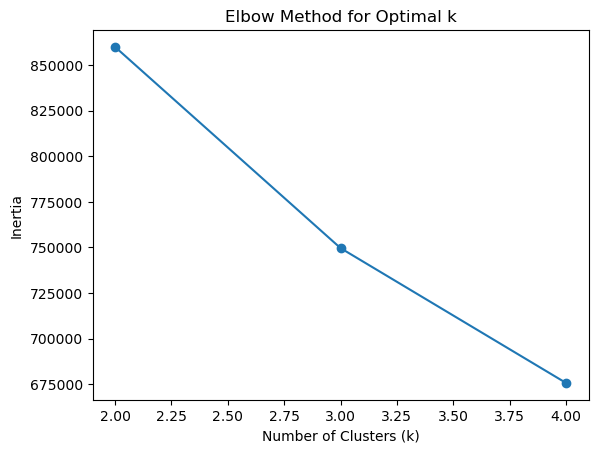

In [65]:
# Assuming famd_data is your feature matrix
famd_data = user_data_famd_result.values

# Try different values of k
k_values = range(2, 5)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(famd_data)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


* The Elbow Method is a heuristic used to determine the optimal number of clusters (k) by analyzing the inertia values. In your case, the plot shows that the inertia decreases and then the rate of decrease slows down, forming an "elbow" at k=3. The point where the inertia starts to level off is considered a suitable choice for the number of clusters, and in this scenario, k=3 was chosen to strike a balance between reducing inertia and avoiding excessive complexity in the clustering.

* So optimal number of clusters is 3.

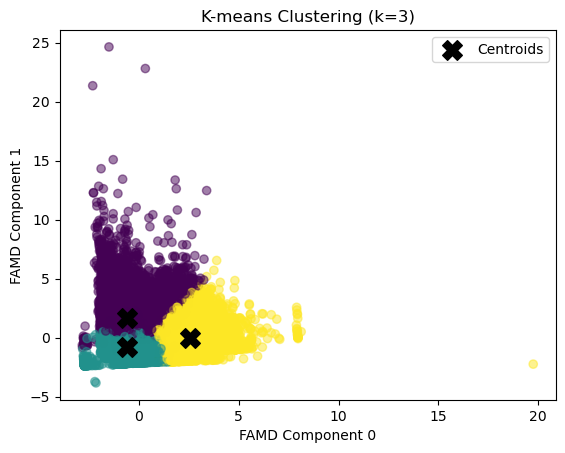

In [66]:
# Choose the optimal k based on the Elbow Method 
optimal_k =3

# Apply K-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(famd_data)

# Visualize the clusters
plt.scatter(famd_data[:, 0], famd_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.xlabel('FAMD Component 0')
plt.ylabel('FAMD Component 1')
plt.title(f'K-means Clustering (k={optimal_k})')
plt.legend()
plt.show()

* Let us implement K-means++.

Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!
Convergence found!


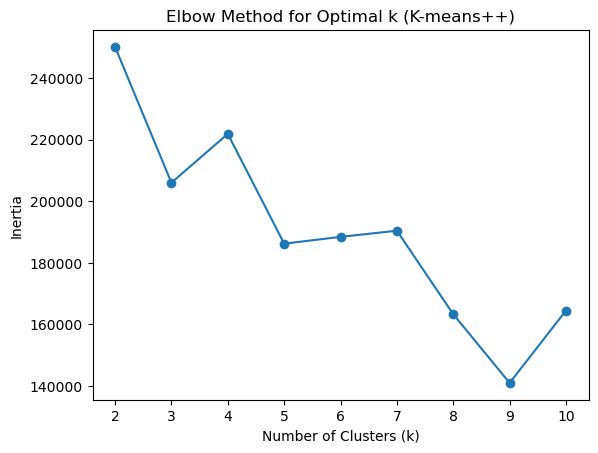

In [67]:
def kmeans_plusplus(data, k, max_iterations=100):
    # Step 1: Randomly choose the first centroid
    centroids = [data[np.random.choice(len(data))]]

    for _ in range(k - 1):
        # Step 2: For each data point, compute its distance to the nearest existing centroid
        distances = np.array([min(np.linalg.norm(point - centroid) for centroid in centroids) for point in data])

        # Step 3: Choose the next centroid from the data points with probability proportional to distance squared
        probabilities = distances**2 / sum(distances**2)
        next_centroid = data[np.random.choice(len(data), p=probabilities)]

        centroids.append(next_centroid)

    # Run standard K-means with the obtained initial centroids
    return kmeans(data, np.array(centroids), max_iterations)

def kmeans(data, initial_centroids, max_iterations=100):
    centroids = initial_centroids
    for iteration in range(max_iterations):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(data[:, None] - centroids, axis=2), axis=1)

        # Update centroids based on the mean of data points in each cluster
        new_centroids = np.array([data[labels == c].mean(axis=0) for c in range(len(centroids))])

        # Check for convergence
        if np.allclose(new_centroids, centroids, rtol=0.1):
            print("Convergence found!")
            break

        centroids = new_centroids

    return labels, centroids

# Assuming famd_data is your feature matrix
famd_data = user_data_famd_result.values

# Determine the optimal number of clusters using the Elbow Method
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    _, centroids = kmeans_plusplus(famd_data, k)
    inertia_values.append(sum(np.min(np.linalg.norm(famd_data[:, None] - centroids, axis=2), axis=1)))

# Plot the Elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (K-means++)')
plt.show()


* In the K-means++ variant, the decrease in inertia stops at k=5, that point on the Elbow curve indicates a potential optimal number of clusters. In this case, choosing k=5 aligns with the point where additional clusters contribute less to reducing the overall inertia, suggesting a meaningful clustering solution.

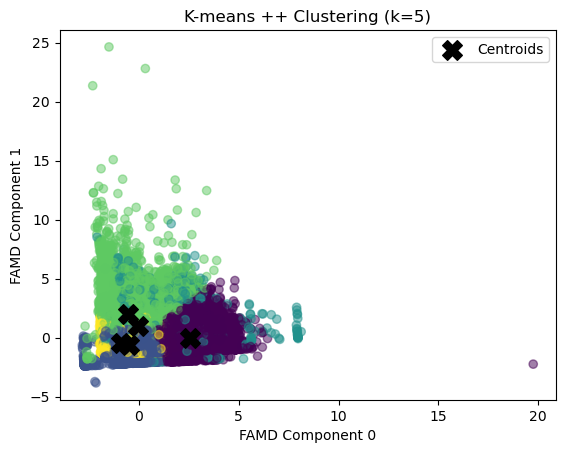

In [68]:
# Choose the optimal k based on the Elbow Method 
optimal_k =5

# Apply K-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(famd_data)

# Visualize the clusters
plt.scatter(famd_data[:, 0], famd_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.xlabel('FAMD Component 0')
plt.ylabel('FAMD Component 1')
plt.title(f'K-means ++ Clustering (k={optimal_k})')
plt.legend()
plt.show()

* K-means++ is an improvement over the standard K-means initialization by providing a more sophisticated method for selecting initial centroids. It aims to distribute the initial centroids more effectively across the data, which often leads to faster convergence and more reliable results. The primary difference lies in the initialization step, where K-means++ improves the starting positions of centroids, potentially resulting in a better final clustering outcome compared to the random initialization used in the standard K-means.

* The differences in cluster separation between K-means and K-means++ may arise due to variations in the initialization of centroids. K-means++ aims to improve initialization, but if the dataset lacks distinct cluster structures or contains outliers, the resulting clusters may still exhibit less separation, impacting the overall clustering performance as in our case. The clusters are less separated in the K-means++ scenario for our case.

* Among other clustering algorithms ChatGPT suggested DBSCAN (Density-Based Spatial Clustering of Applications with Noise). This is a density-based clustering algorithm that groups together data points that are close to each other and marks outliers as noise. Unlike K-means, DBSCAN does not require specifying the number of clusters beforehand. It defines clusters based on the density of data points.

In [69]:
#from sklearn.cluster import DBSCAN
#import matplotlib.pyplot as plt

# Assuming famd_data is your feature matrix
#famd_data = user_data_famd_result.values

# Initialize and fit DBSCAN
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#labels_dbscan = dbscan.fit_predict(famd_data)

# Plot DBSCAN results
#plt.scatter(famd_data[:, 0], famd_data[:, 1], c=labels_dbscan, cmap='viridis', alpha=0.5)
#plt.title('DBSCAN Clustering Results')
#plt.xlabel('Component 0')
#plt.ylabel('Component 1')
#plt.show()


* DBSCAN is a density-based clustering algorithm that automatically identifies clusters based on data density, eliminating the need to specify the number of clusters in advance. In contrast to K-means, DBSCAN excels in handling irregularly shaped clusters and detecting outliers, offering greater flexibility for diverse datasets.